In [1]:
from pyspark.sql import SparkSession
import os
import tempfile
import urllib.request

# Create Spark session
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("recommender-system") \
    .getOrCreate()

# Correct raw GitHub URL and safe local path (no leading slash in filename)
url = "https://raw.githubusercontent.com/Apress/machine-learning-with-pyspark/master/chapter_8_Recommender_System/movie_ratings_df.csv"
local_path = os.path.join(tempfile.gettempdir(), "movie_ratings_df.csv")

# Download dataset (overwrites if already present)
urllib.request.urlretrieve(url, local_path)

# Read with Spark
df = spark.read.csv(local_path, header=True, inferSchema=True)

# Quick sanity check
print(f"Loaded file: {local_path} (exists={os.path.exists(local_path)})")
df.show(5)

Loaded file: /tmp/movie_ratings_df.csv (exists=True)
+------+------------+------+
|userId|       title|rating|
+------+------------+------+
|   196|Kolya (1996)|     3|
|    63|Kolya (1996)|     3|
|   226|Kolya (1996)|     5|
|   154|Kolya (1996)|     3|
|   306|Kolya (1996)|     5|
+------+------------+------+
only showing top 5 rows


In [2]:
df.count(), df.columns

(100000, ['userId', 'title', 'rating'])

In [3]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)



In [4]:
df.describe().show()

+-------+------------------+--------------------+------------------+
|summary|            userId|               title|            rating|
+-------+------------------+--------------------+------------------+
|  count|            100000|              100000|            100000|
|   mean|         462.48475|                NULL|           3.52986|
| stddev|266.61442012750865|                NULL|1.1256735991443156|
|    min|                 1|'Til There Was Yo...|                 1|
|    max|               943|� k�ldum klaka (C...|                 5|
+-------+------------------+--------------------+------------------+



# Exploratory analysis

In [5]:
from pyspark.sql.functions import rand

sample_size = 10  # change as needed
sample_df = df.orderBy(rand()).limit(sample_size)
sample_df.show(sample_size, truncate=False)

+------+---------------------------------+------+
|userId|title                            |rating|
+------+---------------------------------+------+
|121   |Sense and Sensibility (1995)     |4     |
|347   |Addams Family Values (1993)      |1     |
|200   |Blade Runner (1982)              |5     |
|297   |Dead Poets Society (1989)        |4     |
|178   |E.T. the Extra-Terrestrial (1982)|4     |
|189   |Jean de Florette (1986)          |5     |
|561   |True Romance (1993)              |3     |
|354   |FairyTale: A True Story (1997)   |4     |
|562   |Piano, The (1993)                |4     |
|286   |E.T. the Extra-Terrestrial (1982)|4     |
+------+---------------------------------+------+



In [6]:
df.groupBy('userId').count().orderBy('count', ascending=False).show(10, False)

+------+-----+
|userId|count|
+------+-----+
|405   |737  |
|655   |685  |
|13    |636  |
|450   |540  |
|276   |518  |
|416   |493  |
|537   |490  |
|303   |484  |
|234   |480  |
|393   |448  |
+------+-----+
only showing top 10 rows


In [7]:
df.groupBy('userId').count().orderBy('count', ascending=True).show(10, False)

+------+-----+
|userId|count|
+------+-----+
|19    |20   |
|143   |20   |
|309   |20   |
|34    |20   |
|202   |20   |
|732   |20   |
|441   |20   |
|685   |20   |
|824   |20   |
|631   |20   |
+------+-----+
only showing top 10 rows


In [8]:
df.groupBy('title').count().orderBy('count', ascending=False).show(10, False)

+-----------------------------+-----+
|title                        |count|
+-----------------------------+-----+
|Star Wars (1977)             |583  |
|Contact (1997)               |509  |
|Fargo (1996)                 |508  |
|Return of the Jedi (1983)    |507  |
|Liar Liar (1997)             |485  |
|English Patient, The (1996)  |481  |
|Scream (1996)                |478  |
|Toy Story (1995)             |452  |
|Air Force One (1997)         |431  |
|Independence Day (ID4) (1996)|429  |
+-----------------------------+-----+
only showing top 10 rows


In [9]:
# Feature Engineering

In [10]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, IndexToString

In [11]:
stringIndexer = StringIndexer(inputCol='title', outputCol='title_new')
model = stringIndexer.fit(df)
indexed = model.transform(df)
indexed.show(5)

+------+------------+------+---------+
|userId|       title|rating|title_new|
+------+------------+------+---------+
|   196|Kolya (1996)|     3|    287.0|
|    63|Kolya (1996)|     3|    287.0|
|   226|Kolya (1996)|     5|    287.0|
|   154|Kolya (1996)|     3|    287.0|
|   306|Kolya (1996)|     5|    287.0|
+------+------------+------+---------+
only showing top 5 rows


In [12]:
indexed.groupBy('title_new').count().orderBy('count', ascending=False).show(10, False)

+---------+-----+
|title_new|count|
+---------+-----+
|0.0      |583  |
|1.0      |509  |
|2.0      |508  |
|3.0      |507  |
|4.0      |485  |
|5.0      |481  |
|6.0      |478  |
|7.0      |452  |
|8.0      |431  |
|9.0      |429  |
+---------+-----+
only showing top 10 rows


In [13]:
# Splitting the data into training and test sets

In [14]:
train, test = indexed.randomSplit([0.75, 0.25], seed=42)

train.count(), test.count()

(74998, 25002)

In [15]:
# Building the recommendation model using ALS (Alternating Least Squares)

In [16]:
from pyspark.ml.recommendation import ALS

In [ ]:
rec = ALS(maxIter=10, regParam=0.01,
          userCol='userId',
          itemCol='title_new',
          ratingCol='rating',
          coldStartStrategy="drop",
          nonnegative=True,
          seed=42)

rec_model = rec.fit(train)

In [33]:
rec_model.userFactors.show(5, False)

+---+-----------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                         |
+---+-----------------------------------------------------------------------------------------------------------------+
|10 |[0.17888081, 0.3228659, 0.43708283, 0.5454624, 0.6167099, 0.6390707, 0.59710073, 1.364871, 0.8377565, 0.7005153] |
|20 |[2.978023, 0.0, 2.1974392, 0.09069832, 0.21164122, 0.0, 0.0, 0.8307876, 0.0, 0.37476385]                         |
|30 |[0.3836588, 0.6007229, 0.13447823, 0.8872036, 1.0458249, 0.02571405, 0.5775206, 1.5185736, 0.43187237, 0.7686698]|
|40 |[0.21955208, 0.0, 0.68653584, 1.0438461, 0.0, 0.31299067, 0.0, 1.0433594, 0.61180145, 0.7487539]                 |
|50 |[0.7836244, 0.0, 0.22449417, 0.49809077, 2.6277509, 0.066779755, 2.0284233, 0.18820637, 0.0, 0.13991627]         |
+---+-----------------------------------

In [34]:
rec_model.itemFactors.show(5, False)

+---+--------------------------------------------------------------------------------------------------------------------+
|id |features                                                                                                            |
+---+--------------------------------------------------------------------------------------------------------------------+
|0  |[0.16066729, 0.0, 0.026495954, 0.78164697, 0.0, 0.9509615, 0.002408314, 2.0225258, 0.16251276, 0.9375548]           |
|10 |[0.16288243, 0.031724364, 0.053742517, 0.42010498, 0.0, 0.98259026, 0.0, 2.1066735, 0.028923456, 0.982166]          |
|20 |[0.29289958, 0.023079636, 0.17107424, 0.2545934, 0.0, 0.91223335, 0.46981126, 1.7048002, 0.1149146, 1.023756]       |
|30 |[0.008473841, 0.5779887, 0.36791494, 1.1691294, 0.54849464, 0.29045224, 0.14994033, 1.269256, 1.0188304, 0.21786287]|
|40 |[0.34112695, 0.12728965, 0.43946913, 0.39694107, 0.10895834, 1.2414963, 0.48172995, 1.4029782, 0.2755354, 0.8059903]|
+---+-----------

# Predictions and Evaluation

In [18]:
predicted_ratings = rec_model.transform(test)
predicted_ratings.printSchema()
predicted_ratings.orderBy(rand()).show(10, False)

root
 |-- userId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- title_new: integer (nullable = true)
 |-- prediction: float (nullable = false)

+------+-----------------------------------------+------+---------+----------+
|userId|title                                    |rating|title_new|prediction|
+------+-----------------------------------------+------+---------+----------+
|790   |Brady Bunch Movie, The (1995)            |4     |433      |2.5830762 |
|620   |Jumanji (1995)                           |5     |348      |3.6472898 |
|303   |Last Man Standing (1996)                 |2     |584      |2.75623   |
|782   |Tetsuo II: Body Hammer (1992)            |3     |1284     |2.5778978 |
|422   |Return of the Jedi (1983)                |4     |3        |3.6562958 |
|13    |Candyman (1992)                          |1     |503      |1.5392804 |
|452   |Butch Cassidy and the Sundance Kid (1969)|3     |101      |4.0773215 |
|22  

In [19]:
predicted_ratings.describe().show()

+-------+-----------------+--------------------+------------------+------------------+------------------+
|summary|           userId|               title|            rating|         title_new|        prediction|
+-------+-----------------+--------------------+------------------+------------------+------------------+
|  count|            24943|               24943|             24943|             24943|             24943|
|   mean|462.3705648879445|                NULL|3.5339373772200617|306.29246682435956|3.5416852498874865|
| stddev|265.2141419496299|                NULL|1.1298683987242488| 296.6218928669646|0.8697261234818273|
|    min|                1|'Til There Was Yo...|                 1|                 0|               0.0|
|    max|              943|             unknown|                 5|              1529|          9.205758|
+-------+-----------------+--------------------+------------------+------------------+------------------+



In [20]:
predicted_ratings.orderBy('prediction',ascending=False).show(10, False)

+------+-----------------------------------------------------------+------+---------+----------+
|userId|title                                                      |rating|title_new|prediction|
+------+-----------------------------------------------------------+------+---------+----------+
|731   |Paradise Lost: The Child Murders at Robin Hood Hills (1996)|1     |928      |9.205758  |
|180   |Safe (1995)                                                |5     |1057     |8.772025  |
|427   |Wishmaster (1997)                                          |5     |836      |8.523086  |
|565   |Tie Me Up! Tie Me Down! (1990)                             |5     |776      |8.505151  |
|97    |Body Snatchers (1993)                                      |5     |467      |8.089277  |
|572   |Basquiat (1996)                                            |2     |648      |7.968692  |
|434   |Crow: City of Angels, The (1996)                           |1     |714      |7.8812532 |
|673   |Apostle, The (1997)   

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predicted_ratings)
print(f"Root-mean-square error = {rmse}")

Root-mean-square error = 1.0300949174508718


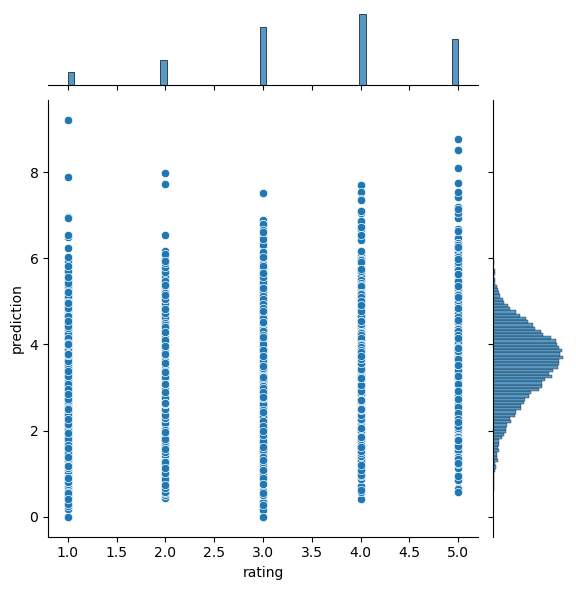

In [30]:
import seaborn as sns

preds_and_labels = predicted_ratings.select('prediction', 'rating').toPandas()

sns.jointplot(x='rating', y='prediction', data=preds_and_labels)


# Let's recommend

In [22]:
# Distinct movies in the dataset

unique_movies = indexed.select('title_new').distinct()
print(unique_movies.count())
unique_movies.show(5)

a = unique_movies.alias('a')

1664
+---------+
|title_new|
+---------+
|    305.0|
|    596.0|
|    299.0|
|    769.0|
|    692.0|
+---------+
only showing top 5 rows


In [23]:
# Movies watched by a specific user

user_id = 85

watched_movies = indexed.filter(indexed['userId'] == user_id).select('title_new').distinct()
print(watched_movies.count())

watched_movies.show(5)

b=watched_movies.alias('b')

287
+---------+
|title_new|
+---------+
|    305.0|
|    558.0|
|    147.0|
|     70.0|
|     67.0|
+---------+
only showing top 5 rows


In [24]:
# Movies not yet watched by the user

total_movies = a.join(b, a.title_new == b.title_new, how='left')
total_movies.show()

+---------+---------+
|title_new|title_new|
+---------+---------+
|    305.0|    305.0|
|    596.0|     NULL|
|    299.0|     NULL|
|    769.0|     NULL|
|    692.0|     NULL|
|    934.0|     NULL|
|   1051.0|     NULL|
|    496.0|     NULL|
|    558.0|    558.0|
|    170.0|     NULL|
|    184.0|     NULL|
|    576.0|     NULL|
|    147.0|    147.0|
|    810.0|     NULL|
|    720.0|     NULL|
|    782.0|     NULL|
|   1369.0|     NULL|
|   1587.0|     NULL|
|    160.0|     NULL|
|    608.0|     NULL|
+---------+---------+
only showing top 20 rows


In [25]:
remaining_movies = total_movies.where(col('b.title_new').isNull()).select('a.title_new').distinct()
print(remaining_movies.count())
remaining_movies.show(5)


1377
+---------+
|title_new|
+---------+
|    596.0|
|    299.0|
|    769.0|
|    692.0|
|    934.0|
+---------+
only showing top 5 rows


In [26]:
remaining_movies = remaining_movies.withColumn('userId', lit(int(user_id)))
remaining_movies.show(5)

+---------+------+
|title_new|userId|
+---------+------+
|    596.0|    85|
|    299.0|    85|
|    769.0|    85|
|    692.0|    85|
|    934.0|    85|
+---------+------+
only showing top 5 rows


In [27]:
recommendations = rec_model.transform(remaining_movies).orderBy('prediction', ascending=False)

recommendations.show(10, False)

+---------+------+----------+
|title_new|userId|prediction|
+---------+------+----------+
|1289     |85    |5.927988  |
|1347     |85    |5.6707764 |
|1028     |85    |5.028058  |
|984      |85    |4.973321  |
|1288     |85    |4.881255  |
|1321     |85    |4.6206026 |
|1054     |85    |4.5579696 |
|1198     |85    |4.524451  |
|1207     |85    |4.502366  |
|1306     |85    |4.5005054 |
+---------+------+----------+
only showing top 10 rows


In [29]:
movie_title = IndexToString(inputCol='title_new', outputCol='movie_title',
                            labels=model.labels)

final_recommendations = movie_title.transform(recommendations)
final_recommendations.show(20, False)

+---------+------+----------+--------------------------------------+
|title_new|userId|prediction|movie_title                           |
+---------+------+----------+--------------------------------------+
|1289     |85    |5.927988  |World of Apu, The (Apur Sansar) (1959)|
|1347     |85    |5.6707764 |Angel Baby (1995)                     |
|1028     |85    |5.028058  |Braindead (1992)                      |
|984      |85    |4.973321  |Bad Taste (1987)                      |
|1288     |85    |4.881255  |Whole Wide World, The (1996)          |
|1321     |85    |4.6206026 |Of Human Bondage (1934)               |
|1054     |85    |4.5579696 |Primary Colors (1998)                 |
|1198     |85    |4.524451  |Pather Panchali (1955)                |
|1207     |85    |4.502366  |Aparajito (1956)                      |
|1306     |85    |4.5005054 |Faust (1994)                          |
|108      |85    |4.4457107 |Rear Window (1954)                    |
|1518     |85    |4.441387  |Some 

In [39]:
recommendations = rec_model.recommendForAllUsers(5)


In [41]:

# convert to movie titles
recomm = recommendations.withColumn('rec_expanded',
                                             explode('recommendations')).select('userId', col('rec_expanded.title_new'), col('rec_expanded.rating'))
recomm = movie_title.transform(recomm)

recomm.show(15, False)

+------+---------+---------+-----------------------------------------------------------+
|userId|title_new|rating   |movie_title                                                |
+------+---------+---------+-----------------------------------------------------------+
|1     |794      |5.800436 |FairyTale: A True Story (1997)                             |
|1     |766      |5.712688 |Brassed Off (1996)                                         |
|1     |0        |5.40884  |Star Wars (1977)                                           |
|1     |285      |5.3433022|Wrong Trousers, The (1993)                                 |
|1     |302      |5.3254957|Close Shave, A (1995)                                      |
|2     |1207     |6.4685287|Aparajito (1956)                                           |
|2     |1289     |6.4091635|World of Apu, The (Apur Sansar) (1959)                     |
|2     |950      |6.196776 |Amateur (1994)                                             |
|2     |779      |5.7